# Neural SDEs

`torchdyn` NeuralSDE implementation relies on XuChen Li's `torchsde` implementation of several SDE solvers and sensitivity analysis tools.

In this tutorial we briefly introduce NeuralSDEs in `torchdyn`, with basic implementation of both *Ito* and *Stratonivich* -type SDEs

In [1]:
import sys ; sys.path.append('../../')
from torchdyn.models import *
from torchdyn.datasets import *
from torchdyn import *

In [2]:
import torch 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Define a NeuralSDE Model

In this example we consider Stratonovich NeuralSDEs in the form 

$ \left\{
    \begin{aligned}
        z(0) &= h_x(x)\\
        d z &= f_\theta(t, z)dt + \sum_{i=1}^n g_{\theta,i}(t, z)dW_i(t)\\
        y(t) &= h_y(z(t))
    \end{aligned}
 \right.
$

with $f_\theta$, $g_\theta$ being dependent on some parameters $\theta$

In [3]:
from torch.distributions import Uniform
prior = Uniform(-torch.ones(2).to(device), torch.ones(2).to(device))

In [4]:
class DuffinOscillator(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        q, p =   x[:,:1], x[:,1:]
        dqdt = p
        dpdt = -4*(q**3) + 2*q - p
        return torch.cat([dqdt, dpdt], 1)

In [5]:
f = DuffinOscillator()
g = nn.Sequential(nn.Linear(2, 32), 
                  nn.Softplus(), 
                  nn.Linear(32, 32), 
                  nn.Softplus(), 
                  nn.Linear(32, 1), Augmenter(1, 1))
for p in g[-1].parameters(): torch.nn.init.zeros_(p)

nsde = NeuralSDE(f, g,
                noise_type='diagonal',
                sde_type='stratonovich',
                sensitivity='adjoint',
                s_span=torch.linspace(0, 2, 100),
                solver='euler',
                atol=0.0001,
                rtol=0.0001).to(device)

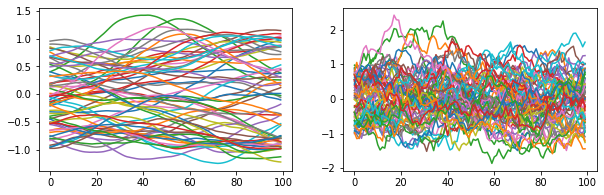

In [6]:
bs = 64 ; s_span = torch.linspace(0, 2, 100)
x0 = prior.sample(torch.Size([bs]))
traj = nsde.trajectory(x0, s_span).detach().cpu()

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
for i in range(bs):
    ax[0].plot(traj[:,i,0])
    ax[1].plot(traj[:,i,1])

In [7]:
#dummy dataloader 
trainloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.Tensor(1), torch.Tensor(1)), batch_size=1, shuffle=True)
import pytorch_lightning as pl

bs = 2 << 10
class Learner(pl.LightningModule):
    def __init__(self, model:nn.Module):
        super().__init__()
        self.model = model
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x0 = prior.sample(torch.Size([bs]))
        xT = self.model(x0)   
        loss = torch.norm(xT - torch.Tensor([0.5, 0.]).to(x0), p=2, dim=1).mean()
        logs = {'train_loss': loss}
        return {'loss': loss, 'log': logs}   
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.01)

    def train_dataloader(self):
        return trainloader

In [ ]:
learn = Learner(nsde)
trainer = pl.Trainer(max_epochs=500)
trainer.fit(learn)

INFO:lightning:
  | Name                  | Type             | Params
-------------------------------------------------------
0 | model                 | NeuralSDE        | 1 K   
1 | model.defunc          | SDEFunc          | 1 K   
2 | model.defunc.f_func   | DuffinOscillator | 0     
3 | model.defunc.g_func   | Sequential       | 1 K   
4 | model.defunc.g_func.0 | Linear           | 96    
5 | model.defunc.g_func.1 | Softplus         | 0     
6 | model.defunc.g_func.2 | Linear           | 1 K   
7 | model.defunc.g_func.3 | Softplus         | 0     
8 | model.defunc.g_func.4 | Linear           | 33    
9 | model.defunc.g_func.5 | Augmenter        | 0     


C:\Users\stefano\Anaconda3\lib\site-packages\pytorch_lightning\utilities\warnings.py:18: RuntimeWarning: Displayed epoch numbers in the progress bar start from "1" until v0.6.x, but will start from "0" in v0.8.0.
  warnings.warn(*args, **kwargs)


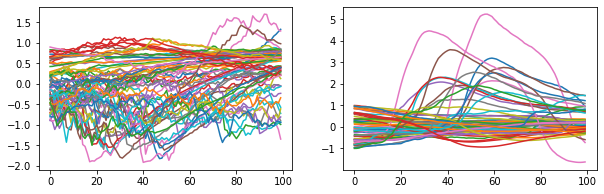

In [10]:
bs = 64 ; s_span = torch.linspace(0, 2, 100)
x0 = prior.sample(torch.Size([bs]))
traj = nsde.trajectory(x0, s_span).detach().cpu()

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
for i in range(bs):
    ax[0].plot(traj[:,i,0])
    ax[1].plot(traj[:,i,1])

In [11]:
def grid_apply_vec(X, Y, func):
    z = torch.cat([X.reshape(-1,1), Y.reshape(-1,1)], 1)
    y = func(z).detach()
    U, V = y[:,0].reshape(X.shape), y[:,1].reshape(X.shape)
    return U, V

Text(0.5, 1.0, 'diffusion vector field $g_\\theta(t, x)$')

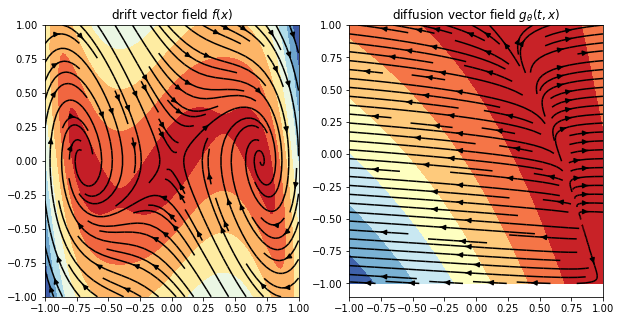

In [12]:
x = torch.linspace(-1, 1, 100) ; X, Y = torch.meshgrid(x, x)
Uf, Vf = grid_apply_vec(X, Y, f.cpu()) ; Ug, Vg = grid_apply_vec(X, Y, g.cpu())

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].streamplot(X.numpy().T, Y.numpy().T, Uf.numpy().T, Vf.numpy().T, color='black')
ax[0].contourf(X.T, Y.T, torch.sqrt(Uf.T**2+Vf.T**2), cmap='RdYlBu')
ax[1].streamplot(X.numpy().T, Y.numpy().T, Ug.numpy().T, Vg.numpy().T, color='black')
ax[1].contourf(X.T, Y.T, torch.sqrt(Ug.T**2+Vg.T**2), cmap='RdYlBu')

ax[0].set_title(r'drift vector field $f(x)$') ; ax[1].set_title(r'diffusion vector field $g_\theta(t, x)$')